### Time Series Workshop 
# 3. Air Pollutants &#x1F525;: Feature Engineering

In this notebook, we will continue to work with our well known air-pollutants data set and introduce common feature engineering techniques for time series forecasting.

In [2]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from timeseries.data import load_air_quality
from feature_engine.creation import CyclicalFeatures

DATA_DIR = Path("..") / Path("data")

## Load and process data

In [3]:
FILE_PATH = DATA_DIR / "air_quality.csv"

df_in = load_air_quality(FILE_PATH)
df_in.head()

variables = ["co_sensor", "humidity"]
df_in = df_in[variables].copy()

for var in variables:
    df_in = df_in[df_in[var] >= 0]

df_in.head()


,co_sensor,humidity
date_time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


## Time related features

In [4]:
df = df_in.copy()

df["month"] = df.index.month
df["week"] = df.index.isocalendar().week
df["day"] = df.index.day
df["day_of_week"] = df.index.day_of_week
df["hour"] = df.index.hour
df["is_weekend"] = np.where(df["day_of_week"] > 4, 1, 0)
df.head()

,co_sensor,humidity,month,week,day,day_of_week,hour,is_weekend
date_time,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,4,14,4,6,0,1
2004-04-04 01:00:00,1215.0,59.2,4,14,4,6,1,1
2004-04-04 02:00:00,1115.0,62.4,4,14,4,6,2,1
2004-04-04 03:00:00,1124.0,65.0,4,14,4,6,3,1
2004-04-04 04:00:00,1028.0,65.3,4,14,4,6,4,1


## Lag features
Lag features are past values of the variable that we can use to predict future values.

Here, we will use the following lag features to predict the next hour's pollutant concentration:
- The pollutant concentration for the previous three hours (t-1, t-2, t-3).
- The pollutant concentration for the same hour on the previous day (t-24).

The reasoning behind this is that pollutant concentrations do not change quickly and, as previously demonstrated, have a 24-hour seasonality.

In [5]:
df_processed_0 = df.copy()

for var in variables:
    for h in [1, 2, 3, 24]:
        tmp = df_processed_0[[var]].shift(freq=f"{h}H")
        tmp.columns = [f"{var}_lag_{h}"]
        df_processed_0 = df_processed_0.merge(
            tmp, left_index=True, right_index=True, how="left"
        )


df_processed_0.head()

,co_sensor,humidity,month,week,day,day_of_week,hour,is_weekend,co_sensor_lag_1,co_sensor_lag_2,co_sensor_lag_3,co_sensor_lag_24,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_24
date_time,,,,,,,,,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,4,14,4,6,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-04 01:00:00,1215.0,59.2,4,14,4,6,1,1,1224.0,NaN,NaN,NaN,56.5,NaN,NaN,NaN
2004-04-04 02:00:00,1115.0,62.4,4,14,4,6,2,1,1215.0,1224.0,NaN,NaN,59.2,56.5,NaN,NaN
2004-04-04 03:00:00,1124.0,65.0,4,14,4,6,3,1,1115.0,1215.0,1224.0,NaN,62.4,59.2,56.5,NaN
2004-04-04 04:00:00,1028.0,65.3,4,14,4,6,4,1,1124.0,1115.0,1215.0,NaN,65.0,62.4,59.2,NaN


In [6]:
# Sanity check for the first 3 hour lags:
df_processed_0[
    ["co_sensor", "co_sensor_lag_1", "co_sensor_lag_2", "co_sensor_lag_3"]
].head()

,co_sensor,co_sensor_lag_1,co_sensor_lag_2,co_sensor_lag_3
date_time,,,,
2004-04-04 00:00:00,1224.0,NaN,NaN,NaN
2004-04-04 01:00:00,1215.0,1224.0,NaN,NaN
2004-04-04 02:00:00,1115.0,1215.0,1224.0,NaN
2004-04-04 03:00:00,1124.0,1115.0,1215.0,1224.0
2004-04-04 04:00:00,1028.0,1124.0,1115.0,1215.0


In [7]:
# Sanity check for the 24 hour lag:
df_processed_0[["co_sensor", "co_sensor_lag_24"]].head(26)


,co_sensor,co_sensor_lag_24
date_time,,
2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,1215.0,NaN
2004-04-04 02:00:00,1115.0,NaN
2004-04-04 03:00:00,1124.0,NaN
2004-04-04 04:00:00,1028.0,NaN
2004-04-04 05:00:00,1010.0,NaN
2004-04-04 06:00:00,1074.0,NaN
2004-04-04 07:00:00,1034.0,NaN
2004-04-04 08:00:00,1130.0,NaN


## Window Features
Window features use some form of aggregation of the features' values over a pre-defined time window of a variable as predictors for the current value.

Here, we will
- Use a rolling window of 5 hours 
- Compute the mean, min, and max values of our variables within this window
- Shift the window forward to serve as predictors for the next hour

In [8]:
tmp = (
    df_processed_0[variables]
    .rolling(window="5H")
    .agg(
        ["mean", "min", "max", "std"]
    )  # Aggregate functions over the span of the window
    .shift(freq="1H")  # Move the average 1 hour forward
)

tmp.columns = tmp.columns.map("_win_".join)
tmp.head()

df_processed_1 = df_processed_0.copy().merge(
    tmp, left_index=True, right_index=True, how="left"
)
df_processed_1.head()

,co_sensor,humidity,month,week,day,day_of_week,hour,is_weekend,co_sensor_lag_1,co_sensor_lag_2,...,humidity_lag_3,humidity_lag_24,co_sensor_win_mean,co_sensor_win_min,co_sensor_win_max,co_sensor_win_std,humidity_win_mean,humidity_win_min,humidity_win_max,humidity_win_std
date_time,,,,,,,,,,,,,,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,4,14,4,6,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-04 01:00:00,1215.0,59.2,4,14,4,6,1,1,1224.0,NaN,...,NaN,NaN,1224.000000,1224.0,1224.0,NaN,56.500000,56.5,56.5,NaN
2004-04-04 02:00:00,1115.0,62.4,4,14,4,6,2,1,1215.0,1224.0,...,NaN,NaN,1219.500000,1215.0,1224.0,6.363961,57.850000,56.5,59.2,1.909188
2004-04-04 03:00:00,1124.0,65.0,4,14,4,6,3,1,1115.0,1215.0,...,56.5,NaN,1184.666667,1115.0,1224.0,60.500689,59.366667,56.5,62.4,2.953529
2004-04-04 04:00:00,1028.0,65.3,4,14,4,6,4,1,1124.0,1115.0,...,59.2,NaN,1169.500000,1115.0,1224.0,57.968382,60.775000,56.5,65.0,3.707987


## Periodic Features

Time-based features are inherently periodic. For example
- Months: 1 -> 2 -> ... -> 12 -> 1 -> ...
- Week days: 1 -> 2 -> ... -> 7 -> 1 -> ...

and so on.

While some models can capture this periodicity without any difficulty (hint: decision trees!), others cannot. Thus, additional processing can be very beneficial for the model performance.

We can encode periodic features using a sine and cosine transformation with the feature's period. This will cause the values of the features that are far apart to come closer. For example, December (12) is closer to January (1) than June (6). This relationship is not captured by the numerical representation of these features. But we could change it, if we transformed these variables with sine and cosine.

While this can, of course, be done with some short calcluations, we'll resort to some ready made transformers from the `feature_engine` package here.

In [9]:
time_vars = ["month", "hour"]

cyclical = CyclicalFeatures(
    variables=time_vars,  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

df_processed_2 = cyclical.fit_transform(df_processed_1)
df_processed_2.head()


,co_sensor,humidity,month,week,day,day_of_week,hour,is_weekend,co_sensor_lag_1,co_sensor_lag_2,...,co_sensor_win_max,co_sensor_win_std,humidity_win_mean,humidity_win_min,humidity_win_max,humidity_win_std,month_sin,month_cos,hour_sin,hour_cos
date_time,,,,,,,,,,,,,,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,4,14,4,6,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.866025,-0.5,0.000000,1.000000
2004-04-04 01:00:00,1215.0,59.2,4,14,4,6,1,1,1224.0,NaN,...,1224.0,NaN,56.500000,56.5,56.5,NaN,0.866025,-0.5,0.269797,0.962917
2004-04-04 02:00:00,1115.0,62.4,4,14,4,6,2,1,1215.0,1224.0,...,1224.0,6.363961,57.850000,56.5,59.2,1.909188,0.866025,-0.5,0.519584,0.854419
2004-04-04 03:00:00,1124.0,65.0,4,14,4,6,3,1,1115.0,1215.0,...,1224.0,60.500689,59.366667,56.5,62.4,2.953529,0.866025,-0.5,0.730836,0.682553
2004-04-04 04:00:00,1028.0,65.3,4,14,4,6,4,1,1124.0,1115.0,...,1224.0,57.968382,60.775000,56.5,65.0,3.707987,0.866025,-0.5,0.887885,0.460065


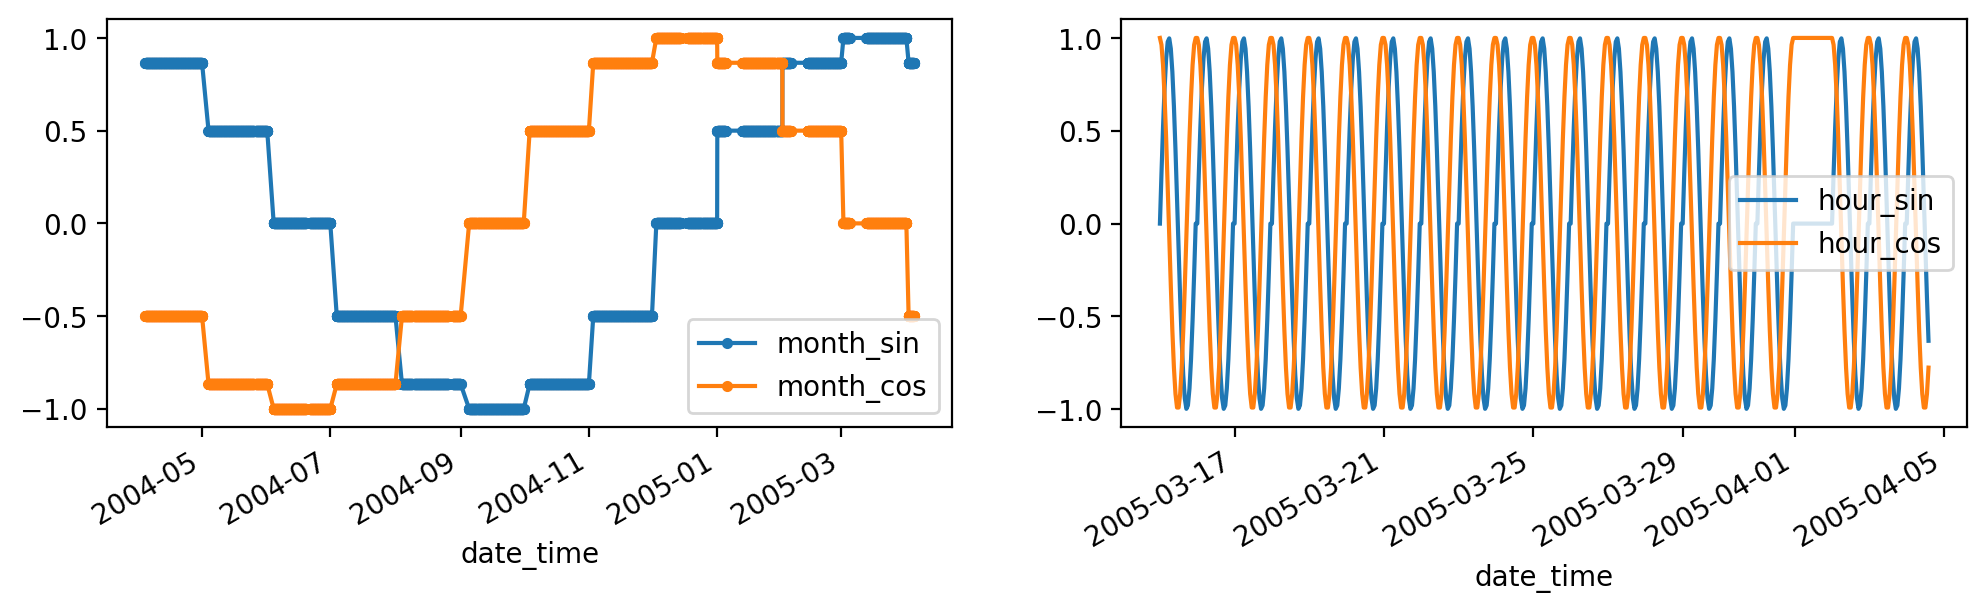

In [10]:
_, axs = plt.subplots(1, 2, figsize=(12, 3))
_ = df_processed_2[["month_sin", "month_cos"]].plot(marker=".", ax=axs[0])
_ = df_processed_2["2005-03-15":][["hour_sin", "hour_cos"]].plot(ax=axs[1])

# Remove missing data and export
- With the lag and window calculations we have introduced a bunch of missing data. 
- These aren't too many though, so we'll simply remove them.
- Finally, we'll also remove the original "humidity" feature as we want to predict the carbon monoxide concentration from the humidity (which we assume we don't know at the time of prediction)

In [11]:
df_processed_2.isnull().sum()


co_sensor               0
humidity                0
month                   0
week                    0
day                     0
day_of_week             0
hour                    0
is_weekend              0
co_sensor_lag_1        27
co_sensor_lag_2        50
co_sensor_lag_3        73
co_sensor_lag_24      461
humidity_lag_1         27
humidity_lag_2         50
humidity_lag_3         73
humidity_lag_24       461
co_sensor_win_mean     27
co_sensor_win_min      27
co_sensor_win_max      27
co_sensor_win_std      49
humidity_win_mean      27
humidity_win_min       27
humidity_win_max       27
humidity_win_std       49
month_sin               0
month_cos               0
hour_sin                0
hour_cos                0
dtype: int64

In [12]:
df_final = df_processed_2.dropna().drop("humidity", axis=1)
df_final.to_csv(DATA_DIR / "air_quality_processed.csv", index=True)


Done!